<a href="https://colab.research.google.com/github/tansaurus/VCMI/blob/main/Using_MulT_with_3_modals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mlflow
!pip install timm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Fri Jul  5 08:41:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# 미래 버전의 Python 기능을 현재 버전에서 사용하도록 설정
from __future__ import print_function

# 데이터 조작 및 계산을 위한 라이브러리
import numpy as np
import pandas as pd

# 머신러닝 및 데이터 분석 라이브러리
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# 시각화 라이브러리
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torchvision.transforms.functional as TF

# 딥러닝 및 이미지 처리 라이브러리
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# 진행률 표시를 위한 라이브러리
from tqdm import tqdm

# 파일 및 디렉토리 작업을 위한 라이브러리
import os
import glob
import zipfile

# 기타
from itertools import chain
import random
from sklearn.metrics import confusion_matrix
import shutil

#mlflow
from mlflow import log_metric, log_param, log_artifacts

In [ ]:
import os
import mlflow

# MLflow 디렉토리 생성
mlflow_dir = '/content/drive/MyDrive/Colab Notebooks/VCMI/20240702/mlruns'
os.makedirs(mlflow_dir, exist_ok=True)

# MLflow 설정
os.environ['MLFLOW_TRACKING_URI'] = mlflow_dir
mlflow.set_tracking_uri(mlflow_dir)

In [ ]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(5000)"))

https://1atsff61ek7-496ff2e9c6d22116-5000-colab.googleusercontent.com/


In [ ]:
import mlflow
experiment_name = "MulT Optimization 3 modals"
mlflow.set_experiment(experiment_name)

params = {
    "lr": 1e-6,
    "batch_size": 16,
    "gamma": 0.8,
    "epochs": 100,
    "seed": 42
}

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(params["seed"])

In [ ]:
device = 'cuda'

In [ ]:
import pandas as pd

train_data_ADC = pd.read_csv('/content/drive/My Drive/Colab Notebooks/VCMI/monomodal_HGG/ADC/train/labels.csv')
valid_data_ADC = pd.read_csv('/content/drive/My Drive/Colab Notebooks/VCMI/monomodal_HGG/ADC/val/labels.csv')
test_data_ADC = pd.read_csv('/content/drive/My Drive/Colab Notebooks/VCMI/monomodal_HGG/ADC/test/labels.csv')

train_data_DWI = pd.read_csv('/content/drive/My Drive/Colab Notebooks/VCMI/monomodal_HGG/DWI/train/labels.csv')
valid_data_DWI = pd.read_csv('/content/drive/My Drive/Colab Notebooks/VCMI/monomodal_HGG/DWI/val/labels.csv')
test_data_DWI = pd.read_csv('/content/drive/My Drive/Colab Notebooks/VCMI/monomodal_HGG/DWI/test/labels.csv')

train_data_T2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/VCMI/monomodal_HGG/T2/train/labels.csv')
valid_data_T2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/VCMI/monomodal_HGG/T2/val/labels.csv')
test_data_T2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/VCMI/monomodal_HGG/T2/test/labels.csv')

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import timm
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image

transform = transforms.Compose([
    #resize((224,224)) 삭제
    transforms.ToTensor(),
])

class Dataset(Dataset):
    def __init__(self, t2_df, dwi_df, adc_df, transform=None):
        self.adc_df = adc_df
        self.dwi_df = dwi_df
        self.t2_df = t2_df
        self.transform = transform

    def __len__(self):
        return len(self.adc_df)

    def __getitem__(self, idx):
        adc_path = self.adc_df.iloc[idx, 0]
        dwi_path = self.dwi_df.iloc[idx, 0]
        t2_path = self.t2_df.iloc[idx, 0]

        adc_image = Image.open(adc_path).convert('RGB')
        dwi_image = Image.open(dwi_path).convert('RGB')
        t2_image = Image.open(t2_path).convert('RGB')

        if self.transform:
            adc_image = self.transform(adc_image)
            dwi_image = self.transform(dwi_image)
            t2_image = self.transform(t2_image)

        label = int(self.adc_df.iloc[idx, 1])

        return t2_image, dwi_image, adc_image, label

def create_dataloader(t2_df, dwi_df, adc_df, batch_size, transform=transform):
    dataset = Dataset(t2_df, dwi_df, adc_df, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer
import timm
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np

from typing import Optional, Any
from argparse import Namespace
import math
from torch.nn import Parameter

#t2->l, dwi->a, adc->v

class MulT(nn.Module):
    def __init__(self, hyp_params):
        super(MulT, self).__init__()
        self.orig_d_t2, self.orig_d_dwi, self.orig_d_adc = hyp_params.orig_d_t2, hyp_params.orig_d_dwi, hyp_params.orig_d_adc
        self.d_l, self.d_a, self.d_v = hyp_params.d_l, hyp_params.d_a, hyp_params.d_v
        self.adc_only = hyp_params.adc_only
        self.dwi_only = hyp_params.dwi_only
        self.t2_only = hyp_params.t2_only
        self.num_heads = hyp_params.num_heads
        self.layers = hyp_params.layers
        self.attn_dropout = hyp_params.attn_dropout
        self.attn_dropout_dwi = hyp_params.attn_dropout_dwi
        self.attn_dropout_t2 = hyp_params.attn_dropout_t2
        self.relu_dropout = hyp_params.relu_dropout
        self.res_dropout = hyp_params.res_dropout
        self.out_dropout = hyp_params.out_dropout
        self.embed_dropout = hyp_params.embed_dropout
        self.attn_mask = hyp_params.attn_mask

        combined_dim = self.d_l + self.d_a + self.d_v

        self.partial_mode = self.t2_only + self.dwi_only + self.adc_only

        if self.partial_mode == 1:
            combined_dim = 2 * self.d_l   # assuming adc_only == dwi_only == t2_only
        else:
            combined_dim = 2 * (self.d_l + self.d_a + self.d_v)

        output_dim = hyp_params.output_dim        # This is actually not a hyperparameter :-)

        # 1. Temporal convolutional layers
        self.proj_l = nn.Linear(self.orig_d_t2 * 100 * 100, self.d_l)
        self.proj_a = nn.Linear(self.orig_d_dwi * 100 * 100, self.d_a)
        self.proj_v = nn.Linear(self.orig_d_adc * 100 * 100, self.d_v)

        # 2. Crossmodal Attentions
        if self.t2_only:
            self.trans_l_with_a = self.get_network(self_type='la')
            self.trans_l_with_v = self.get_network(self_type='lv')
        if self.dwi_only:
            self.trans_a_with_l = self.get_network(self_type='al')
            self.trans_a_with_v = self.get_network(self_type='av')
        if self.adc_only:
            self.trans_v_with_l = self.get_network(self_type='vl')
            self.trans_v_with_a = self.get_network(self_type='va')

        self.trans_l_mem = self.get_network(self_type='l_mem', layers=3)
        self.trans_a_mem = self.get_network(self_type='a_mem', layers=3)
        self.trans_v_mem = self.get_network(self_type='v_mem', layers=3)

        # Projection layers
        self.proj1 = nn.Linear(combined_dim, combined_dim)
        self.proj2 = nn.Linear(combined_dim, combined_dim)
        self.out_layer = nn.Linear(combined_dim, output_dim)

    def get_network(self, self_type='l', layers=-1):
        if self_type in ['l', 'al', 'vl']:
            embed_dim, attn_dropout = self.d_l, self.attn_dropout_t2
        elif self_type in ['a', 'la', 'va']:
            embed_dim, attn_dropout = self.d_a, self.attn_dropout_dwi
        elif self_type in ['v', 'lv', 'av']:
            embed_dim, attn_dropout = self.d_v, self.attn_dropout
        elif self_type == 'l_mem':
            embed_dim, attn_dropout = 2*self.d_l, self.attn_dropout
        elif self_type == 'a_mem':
            embed_dim, attn_dropout = 2*self.d_a, self.attn_dropout
        elif self_type == 'v_mem':
            embed_dim, attn_dropout = 2*self.d_v, self.attn_dropout
        else:
            raise ValueError("Unknown network type")

        return TransformerEncoder(embed_dim=embed_dim,
                                  num_heads=self.num_heads,
                                  layers=max(self.layers, layers),
                                  attn_dropout=attn_dropout,
                                  relu_dropout=self.relu_dropout,
                                  res_dropout=self.res_dropout,
                                  embed_dropout=self.embed_dropout,
                                  attn_mask=self.attn_mask)

    def forward(self, x_l, x_a, x_v):

        x_l = x_l.view(x_l.size(0), -1)
        x_a = x_a.view(x_a.size(0), -1)
        x_v = x_v.view(x_v.size(0), -1)

        # Project the textual/visual/audio features
        proj_x_l = x_l if self.orig_d_t2 == self.t2_only else self.proj_l(x_l)
        proj_x_a = x_a if self.orig_d_dwi == self.dwi_only else self.proj_a(x_a)
        proj_x_v = x_v if self.orig_d_adc == self.adc_only else self.proj_v(x_v)

    # Flatten the features
        proj_x_l = proj_x_l.view(proj_x_l.size(0), proj_x_l.size(1), -1).permute(2, 0, 1)
        proj_x_a = proj_x_a.view(proj_x_a.size(0), proj_x_a.size(1), -1).permute(2, 0, 1)
        proj_x_v = proj_x_v.view(proj_x_v.size(0), proj_x_v.size(1), -1).permute(2, 0, 1)

        if self.t2_only:
            # (V,A) --> L
            h_l_with_as = self.trans_l_with_a(proj_x_l, proj_x_a, proj_x_a)    # Dimension (L, N, adc_only)
            h_l_with_vs = self.trans_l_with_v(proj_x_l, proj_x_v, proj_x_v)    # Dimension (L, N, adc_only)
            h_ls = torch.cat([h_l_with_as, h_l_with_vs], dim=2)
            last_h_l = h_ls[-1]   # Take the last output for prediction

        if self.dwi_only:
            # (L,V) --> A
            h_a_with_ls = self.trans_a_with_l(proj_x_a, proj_x_l, proj_x_l)
            h_a_with_vs = self.trans_a_with_v(proj_x_a, proj_x_v, proj_x_v)
            h_as = torch.cat([h_a_with_ls, h_a_with_vs], dim=2)
            last_h_a = h_as[-1]

        if self.adc_only:
            # (L,A) --> V
            h_v_with_ls = self.trans_v_with_l(proj_x_v, proj_x_l, proj_x_l)
            h_v_with_as = self.trans_v_with_a(proj_x_v, proj_x_a, proj_x_a)
            h_vs = torch.cat([h_v_with_ls, h_v_with_as], dim=2)
            last_h_v = h_vs[-1]

        if self.partial_mode == 3:
            last_hs = torch.cat([last_h_l, last_h_a, last_h_v], dim=1)

    # A residual block
        last_hs_proj = self.proj2(F.dropout(F.relu(self.proj1(last_hs)),
                                            p=self.out_dropout, training=self.training))
        last_hs_proj += last_hs

        output = self.out_layer(last_hs_proj)
        return output, last_hs_proj


class MultiheadAttention(nn.Module):
    """Multi-headed attention.
    See "Attention Is All You Need" for more details.
    """

    def __init__(self, embed_dim, num_heads, attn_dropout=0.,
                 bias=True, add_bias_kv=False, add_zero_attn=False):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.attn_dropout = attn_dropout
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"
        self.scaling = self.head_dim ** -0.5

        self.in_proj_weight = Parameter(torch.Tensor(3 * embed_dim, embed_dim))
        self.register_parameter('in_proj_bias', None)
        if bias:
            self.in_proj_bias = Parameter(torch.Tensor(3 * embed_dim))
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=bias)

        if add_bias_kv:
            self.bias_k = Parameter(torch.Tensor(1, 1, embed_dim))
            self.bias_v = Parameter(torch.Tensor(1, 1, embed_dim))
        else:
            self.bias_k = self.bias_v = None

        self.add_zero_attn = add_zero_attn

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.in_proj_weight)
        nn.init.xavier_uniform_(self.out_proj.weight)
        if self.in_proj_bias is not None:
            nn.init.constant_(self.in_proj_bias, 0.)
            nn.init.constant_(self.out_proj.bias, 0.)
        if self.bias_k is not None:
            nn.init.xavier_normal_(self.bias_k)
        if self.bias_v is not None:
            nn.init.xavier_normal_(self.bias_v)

    def forward(self, query, key, value, attn_mask=None):
        """Input shape: Time x Batch x Channel
        Self-attention can be implemented by passing in the same arguments for
        query, key and value. Timesteps can be masked by supplying a T x T mask in the
        `attn_mask` argument. Padding elements can be excluded from
        the key by passing a binary ByteTensor (`key_padding_mask`) with shape:
        batch x src_len, where padding elements are indicated by 1s.
        """
        qkv_same = query.data_ptr() == key.data_ptr() == value.data_ptr()
        kv_same = key.data_ptr() == value.data_ptr()

        tgt_len, bsz, embed_dim = query.size()
        assert embed_dim == self.embed_dim
        assert list(query.size()) == [tgt_len, bsz, embed_dim]
        assert key.size() == value.size()

        aved_state = None

        if qkv_same:
            # self-attention
            q, k, v = self.in_proj_qkv(query)
        elif kv_same:
            # encoder-decoder attention
            q = self.in_proj_q(query)

            if key is None:
                assert value is None
                k = v = None
            else:
                k, v = self.in_proj_kv(key)
        else:
            q = self.in_proj_q(query)
            k = self.in_proj_k(key)
            v = self.in_proj_v(value)
        q = q * self.scaling

        if self.bias_k is not None:
            assert self.bias_v is not None
            k = torch.cat([k, self.bias_k.repeat(1, bsz, 1)])
            v = torch.cat([v, self.bias_v.repeat(1, bsz, 1)])
            if attn_mask is not None:
                attn_mask = torch.cat([attn_mask, attn_mask.new_zeros(attn_mask.size(0), 1)], dim=1)

        q = q.contiguous().view(tgt_len, bsz * self.num_heads, self.head_dim).transpose(0, 1)
        if k is not None:
            k = k.contiguous().view(-1, bsz * self.num_heads, self.head_dim).transpose(0, 1)
        if v is not None:
            v = v.contiguous().view(-1, bsz * self.num_heads, self.head_dim).transpose(0, 1)

        src_len = k.size(1)

        if self.add_zero_attn:
            src_len += 1
            k = torch.cat([k, k.new_zeros((k.size(0), 1) + k.size()[2:])], dim=1)
            v = torch.cat([v, v.new_zeros((v.size(0), 1) + v.size()[2:])], dim=1)
            if attn_mask is not None:
                attn_mask = torch.cat([attn_mask, attn_mask.new_zeros(attn_mask.size(0), 1)], dim=1)

        attn_weights = torch.bmm(q, k.transpose(1, 2))
        assert list(attn_weights.size()) == [bsz * self.num_heads, tgt_len, src_len]

        if attn_mask is not None:
            try:
                attn_weights += attn_mask.unsqueeze(0)
            except:
                print(attn_weights.shape)
                print(attn_mask.unsqueeze(0).shape)
                assert False

        attn_weights = F.softmax(attn_weights.float(), dim=-1).type_as(attn_weights)
        # attn_weights = F.relu(attn_weights)
        # attn_weights = attn_weights / torch.max(attn_weights)
        attn_weights = F.dropout(attn_weights, p=self.attn_dropout, training=self.training)

        attn = torch.bmm(attn_weights, v)
        assert list(attn.size()) == [bsz * self.num_heads, tgt_len, self.head_dim]

        attn = attn.transpose(0, 1).contiguous().view(tgt_len, bsz, embed_dim)
        attn = self.out_proj(attn)

        # average attention weights over heads
        attn_weights = attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
        attn_weights = attn_weights.sum(dim=1) / self.num_heads
        return attn, attn_weights

    def in_proj_qkv(self, query):
        return self._in_proj(query).chunk(3, dim=-1)

    def in_proj_kv(self, key):
        return self._in_proj(key, start=self.embed_dim).chunk(2, dim=-1)

    def in_proj_q(self, query, **kwargs):
        return self._in_proj(query, end=self.embed_dim, **kwargs)

    def in_proj_k(self, key):
        return self._in_proj(key, start=self.embed_dim, end=2 * self.embed_dim)

    def in_proj_v(self, value):
        return self._in_proj(value, start=2 * self.embed_dim)

    def _in_proj(self, input, start=0, end=None, **kwargs):
        weight = kwargs.get('weight', self.in_proj_weight)
        bias = kwargs.get('bias', self.in_proj_bias)
        weight = weight[start:end, :]
        if bias is not None:
            bias = bias[start:end]
        return F.linear(input, weight, bias)

class SinusoidalPositionalEmbedding(nn.Module):
    """This module produces sinusoidal positional embeddings of any length.
    Padding symbols are ignored, but it is necessary to specify whether padding
    is added on the left side (left_pad=True) or right side (left_pad=False).
    """

    def __init__(self, embedding_dim, padding_idx=0, left_pad=0, init_size=128):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.padding_idx = padding_idx
        self.left_pad = left_pad
        self.weights = dict()   # device --> actual weight; due to nn.DataParallel :-(
        self.register_buffer('_float_tensor', torch.FloatTensor(1))

    @staticmethod
    def get_embedding(num_embeddings, embedding_dim, padding_idx=None):
        """Build sinusoidal embeddings.
        This matches the implementation in tensor2tensor, but differs slightly
        from the description in Section 3.5 of "Attention Is All You Need".
        """
        half_dim = embedding_dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float) * -emb)
        emb = torch.arange(num_embeddings, dtype=torch.float).unsqueeze(1) * emb.unsqueeze(0)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1).view(num_embeddings, -1)
        if embedding_dim % 2 == 1:
            # zero pad
            emb = torch.cat([emb, torch.zeros(num_embeddings, 1)], dim=1)
        if padding_idx is not None:
            emb[padding_idx, :] = 0
        return emb

    def forward(self, input):
        """Input is expected to be of size [bsz x seqlen]."""
        bsz, seq_len = input.size()
        max_pos = self.padding_idx + 1 + seq_len
        device = input.get_device()
        if device not in self.weights or max_pos > self.weights[device].size(0):
            # recompute/expand embeddings if needed
            self.weights[device] = SinusoidalPositionalEmbedding.get_embedding(
                max_pos,
                self.embedding_dim,
                self.padding_idx,
            )
        self.weights[device] = self.weights[device].type_as(self._float_tensor)
        positions = make_positions(input, self.padding_idx, self.left_pad)
        return self.weights[device].index_select(0, positions.view(-1)).view(bsz, seq_len, -1).detach()

    def max_positions(self):
        """Maximum number of supported positions."""
        return int(1e5)  # an arbitrary large number

def make_positions(tensor, padding_idx, left_pad):
    """Replace non-padding symbols with their position numbers.
    Position numbers begin at padding_idx+1.
    Padding symbols are ignored, but it is necessary to specify whether padding
    is added on the left side (left_pad=True) or right side (left_pad=False).
    """
    max_pos = padding_idx + 1 + tensor.size(1)
    device = tensor.get_device()
    buf_name = f'range_buf_{device}'
    if not hasattr(make_positions, buf_name):
        setattr(make_positions, buf_name, tensor.new())
    setattr(make_positions, buf_name, getattr(make_positions, buf_name).type_as(tensor))
    if getattr(make_positions, buf_name).numel() < max_pos:
        torch.arange(padding_idx + 1, max_pos, out=getattr(make_positions, buf_name))
    mask = tensor.ne(padding_idx)
    positions = getattr(make_positions, buf_name)[:tensor.size(1)].expand_as(tensor)
    if left_pad:
        positions = positions - mask.size(1) + mask.long().sum(dim=1).unsqueeze(1)
    new_tensor = tensor.clone()
    return new_tensor.masked_scatter_(mask, positions[mask]).long()


class TransformerEncoder(nn.Module):
    """
    Transformer encoder consisting of *args.encoder_layers* layers. Each layer
    is a :class:`TransformerEncoderLayer`.
    Args:
        embed_tokens (torch.nn.Embedding): input embedding
        num_heads (int): number of heads
        layers (int): number of layers
        attn_dropout (float): dropout applied on the attention weights
        relu_dropout (float): dropout applied on the first layer of the residual block
        res_dropout (float): dropout applied on the residual block
        attn_mask (bool): whether to apply mask on the attention weights
    """

    def __init__(self, embed_dim, num_heads, layers, attn_dropout=0.0, relu_dropout=0.0, res_dropout=0.0,
                 embed_dropout=0.0, attn_mask=False):
        super().__init__()
        self.dropout = embed_dropout      # Embedding dropout
        self.attn_dropout = attn_dropout
        self.embed_dim = embed_dim
        self.embed_scale = math.sqrt(embed_dim)
        self.embed_positions = SinusoidalPositionalEmbedding(embed_dim)

        self.attn_mask = attn_mask

        self.layers = nn.ModuleList([])
        for layer in range(layers):
            new_layer = TransformerEncoderLayer(embed_dim,
                                                num_heads=num_heads,
                                                attn_dropout=attn_dropout,
                                                relu_dropout=relu_dropout,
                                                res_dropout=res_dropout,
                                                attn_mask=attn_mask)
            self.layers.append(new_layer)

        self.register_buffer('version', torch.Tensor([2]))
        self.normalize = True
        if self.normalize:
            self.layer_norm = LayerNorm(embed_dim)

    def forward(self, x_in, x_in_k = None, x_in_v = None):
        """
        Args:
            x_in (FloatTensor): embedded input of shape `(src_len, batch, embed_dim)`
            x_in_k (FloatTensor): embedded input of shape `(src_len, batch, embed_dim)`
            x_in_v (FloatTensor): embedded input of shape `(src_len, batch, embed_dim)`
        Returns:
            dict:
                - **encoder_out** (Tensor): the last encoder layer's output of
                  shape `(src_len, batch, embed_dim)`
                - **encoder_padding_mask** (ByteTensor): the positions of
                  padding elements of shape `(batch, src_len)`
        """
        # embed tokens and positions
        x = self.embed_scale * x_in
        if self.embed_positions is not None:
            x += self.embed_positions(x_in.transpose(0, 1)[:, :, 0]).transpose(0, 1)   # Add positional embedding
        x = F.dropout(x, p=self.dropout, training=self.training)

        if x_in_k is not None and x_in_v is not None:
            # embed tokens and positions
            x_k = self.embed_scale * x_in_k
            x_v = self.embed_scale * x_in_v
            if self.embed_positions is not None:
                x_k += self.embed_positions(x_in_k.transpose(0, 1)[:, :, 0]).transpose(0, 1)   # Add positional embedding
                x_v += self.embed_positions(x_in_v.transpose(0, 1)[:, :, 0]).transpose(0, 1)   # Add positional embedding
            x_k = F.dropout(x_k, p=self.dropout, training=self.training)
            x_v = F.dropout(x_v, p=self.dropout, training=self.training)

        # encoder layers
        intermediates = [x]
        for layer in self.layers:
            if x_in_k is not None and x_in_v is not None:
                x = layer(x, x_k, x_v)
            else:
                x = layer(x)
            intermediates.append(x)

        if self.normalize:
            x = self.layer_norm(x)

        return x

    def max_positions(self):
        """Maximum input length supported by the encoder."""
        if self.embed_positions is None:
            return self.max_source_positions
        return min(self.max_source_positions, self.embed_positions.max_positions())


class TransformerEncoderLayer(nn.Module):
    """Encoder layer block.
    In the original paper each operation (multi-head attention or FFN) is
    postprocessed with: `dropout -> add residual -> layernorm`. In the
    tensor2tensor code they suggest that learning is more robust when
    preprocessing each layer with layernorm and postprocessing with:
    `dropout -> add residual`. We default to the approach in the paper, but the
    tensor2tensor approach can be enabled by setting
    *args.encoder_normalize_before* to ``True``.
    Args:
        embed_dim: Embedding dimension
    """

    def __init__(self, embed_dim, num_heads, attn_dropout=0.1, relu_dropout=0.1, res_dropout=0.1,
                 attn_mask=False):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        self.self_attn = MultiheadAttention(
            embed_dim=self.embed_dim,
            num_heads=self.num_heads,
            attn_dropout=attn_dropout
        )
        self.attn_mask = attn_mask

        self.relu_dropout = relu_dropout
        self.res_dropout = res_dropout
        self.normalize_before = True

        self.fc1 = Linear(self.embed_dim, 4*self.embed_dim)   # The "Add & Norm" part in the paper
        self.fc2 = Linear(4*self.embed_dim, self.embed_dim)
        self.layer_norms = nn.ModuleList([LayerNorm(self.embed_dim) for _ in range(2)])

    def forward(self, x, x_k=None, x_v=None):
        """
        Args:
            x (Tensor): input to the layer of shape `(seq_len, batch, embed_dim)`
            encoder_padding_mask (ByteTensor): binary ByteTensor of shape
                `(batch, src_len)` where padding elements are indicated by ``1``.
            x_k (Tensor): same as x
            x_v (Tensor): same as x
        Returns:
            encoded output of shape `(batch, src_len, embed_dim)`
        """
        residual = x
        x = self.maybe_layer_norm(0, x, before=True)
        mask = buffered_future_mask(x, x_k) if self.attn_mask else None
        if x_k is None and x_v is None:
            x, _ = self.self_attn(query=x, key=x, value=x, attn_mask=mask)
        else:
            x_k = self.maybe_layer_norm(0, x_k, before=True)
            x_v = self.maybe_layer_norm(0, x_v, before=True)
            x, _ = self.self_attn(query=x, key=x_k, value=x_v, attn_mask=mask)
        x = F.dropout(x, p=self.res_dropout, training=self.training)
        x = residual + x
        x = self.maybe_layer_norm(0, x, after=True)

        residual = x
        x = self.maybe_layer_norm(1, x, before=True)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.relu_dropout, training=self.training)
        x = self.fc2(x)
        x = F.dropout(x, p=self.res_dropout, training=self.training)
        x = residual + x
        x = self.maybe_layer_norm(1, x, after=True)
        return x

    def maybe_layer_norm(self, i, x, before=False, after=False):
        assert before ^ after
        if after ^ self.normalize_before:
            return self.layer_norms[i](x)
        else:
            return x

def fill_with_neg_inf(t):
    """FP16-compatible function that fills a tensor with -inf."""
    return t.float().fill_(float('-inf')).type_as(t)


def buffered_future_mask(tensor, tensor2=None):
    dim1 = dim2 = tensor.size(0)
    if tensor2 is not None:
        dim2 = tensor2.size(0)
    future_mask = torch.triu(fill_with_neg_inf(torch.ones(dim1, dim2)), 1+abs(dim2-dim1))
    if tensor.is_cuda:
        future_mask = future_mask.cuda()
    return future_mask[:dim1, :dim2]


def Linear(in_features, out_features, bias=True):
    m = nn.Linear(in_features, out_features, bias)
    nn.init.xavier_uniform_(m.weight)
    if bias:
        nn.init.constant_(m.bias, 0.)
    return m


def LayerNorm(embedding_dim):
    m = nn.LayerNorm(embedding_dim)
    return m



if __name__ == '__main__':
    hyp_params = Namespace(
        orig_d_adc=3,
        orig_d_dwi=3,
        orig_d_t2=3,
        d_l=16,
        d_a=16,
        d_v=16,
        adc_only=True,
        dwi_only=True,
        t2_only=True, #process all three modalities together
        num_heads=16,  # 멀티 헤드 어텐션의 헤드 수
        layers=1,  # 어텐션 레이어 수
        attn_dropout=0.1,  # 어텐션 드롭아웃 비율
        attn_dropout_dwi=0.1,
        attn_dropout_t2=0.1,
        relu_dropout=0.1,
        res_dropout=0.1,
        out_dropout=0.1,
        embed_dropout=0.1,
        attn_mask=True,
        output_dim=1  # 출력 차원 (예: 이진 분류의 경우 1)
    )

    mult_model = MulT(hyp_params)
    mult_model.to(device)

In [ ]:
# loss function
criterion = nn.L1Loss()
# optimizer
optimizer = optim.Adam(mult_model.parameters(), lr=params["lr"])
# scheduler
scheduler = StepLR(optimizer, step_size=40, gamma=params["gamma"])

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = create_dataloader(train_data_ADC, train_data_DWI, train_data_T2, batch_size=params["batch_size"])
valid_dataloader = create_dataloader(valid_data_ADC, valid_data_DWI, valid_data_T2, batch_size=params["batch_size"])
test_dataloader = create_dataloader(test_data_ADC, test_data_DWI, test_data_T2, batch_size=params["batch_size"])

In [ ]:
def extract_features(model, dataloader):
    model.eval()
    all_features = []
    all_labels = []
    all_last_hs = []

    with torch.no_grad():
        for batch in dataloader:
            adc_images, dwi_images, t2_images, labels = batch
            adc_images = adc_images.to(device)
            dwi_images = dwi_images.to(device)
            t2_images = t2_images.to(device)
            labels = labels.to(device)

            outputs, last_hs = model(adc_images, dwi_images, t2_images)
            all_features.append(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_last_hs.append(last_hs.cpu().numpy())

    all_features = np.concatenate(all_features, axis=0)
    all_last_hs = np.concatenate(all_last_hs, axis=0)
    all_labels = np.array(all_labels)

    return all_features, all_labels, all_last_hs

In [ ]:
import torch
import torch.nn.functional as F
from copy import deepcopy

def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for adc_input, dwi_input, t2_input, label in dataloader:
        adc_input, dwi_input, t2_input, label = adc_input.to(device), dwi_input.to(device), t2_input.to(device), label.to(device)

        optimizer.zero_grad()
        outputs, _ = model(adc_input, dwi_input, t2_input)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, target_class=1):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    TP = 0
    FN = 0
    with torch.no_grad():
        for adc_input, dwi_input, t2_input, label in dataloader:
            adc_input, dwi_input, t2_input, label = adc_input.to(device), dwi_input.to(device), t2_input.to(device), label.to(device)

            outputs, _ = model(adc_input, dwi_input, t2_input)
            loss = criterion(outputs, label)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

            # Sensitivity for class '1'
            TP += (predicted.eq(target_class) & label.eq(target_class)).sum().item()
            FN += (predicted.ne(target_class) & label.eq(target_class)).sum().item()

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, sensitivity


train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

def train(model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs, save_file='model_state_dict.pth'):
    best_val_accuracy = 0
    best_val_loss = float('inf')
    best_model_state_dict = None


    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc, sensitivity = validate_epoch(model, valid_loader, criterion)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        scheduler.step()

        if val_acc > best_val_accuracy or (val_acc == best_val_accuracy and val_loss < best_val_loss):
            best_val_accuracy = val_acc
            best_val_loss = val_loss
            best_model_state_dict = deepcopy(model.state_dict())
            print(f"Epoch {epoch+1}: Saving new best model with val_accuracy {val_acc:.4f}")

        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Train Accuracy {train_acc:.4f}, Val Loss {val_loss:.4f}, Val Accuracy {val_acc:.4f}")
        print("lr: ", optimizer.param_groups[0]['lr'])

    if best_model_state_dict:
        model.load_state_dict(best_model_state_dict)
        torch.save(best_model_state_dict, save_file)

    return best_model_state_dict


T-SNE before experiment

In [ ]:
def plot_tsne(features_2d, labels, title):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(8, 6))
    for label in unique_labels:
        indices = np.where(labels == label)
        plt.scatter(features_2d[indices, 0], features_2d[indices, 1], label=f'g{label+1}', alpha=0.5)
    plt.title(title)
    plt.legend()
    plt.show()

def visualize_tsne_before_test(model, train_dataloader, valid_dataloader):
    # 훈련 및 검증 데이터셋의 특성 추출
    train_features, train_labels, train_last_hs = extract_features(model, train_dataloader)
    val_features, val_labels, val_last_hs = extract_features(model, valid_dataloader)

    print(f"Train features shape: {train_features.shape}")
    print(f"Validation features shape: {val_features.shape}")
    print(f"Train last hs shape: {train_last_hs.shape}")
    print(f"Validation last hs shape: {val_last_hs.shape}")

    # 2차원 t-SNE 모델 생성 및 특성 축소
    perplexity_val = min(20, val_last_hs.shape[0] - 1)
    tsne_2d = TSNE(n_components=2, random_state=0, perplexity=perplexity_val)
    train_last_hs_2d = tsne_2d.fit_transform(train_last_hs)
    val_last_hs_2d = tsne_2d.fit_transform(val_last_hs)

    # t-SNE 시각화
    plt.figure(figsize=(12, 6))

    # 2차원 산점도 그리기 - 훈련 데이터셋
    ax1 = plt.subplot(121)
    for label in np.unique(train_labels):
        indices = np.where(train_labels == label)
        ax1.scatter(train_last_hs_2d[indices, 0], train_last_hs_2d[indices, 1], label=f'g{label+1}', alpha=0.5)
    ax1.set_title('Training Dataset Before Training')
    ax1.legend()

    # 2차원 산점도 그리기 - 검증 데이터셋
    ax2 = plt.subplot(122)
    for label in np.unique(val_labels):
        indices = np.where(val_labels == label)
        ax2.scatter(val_last_hs_2d[indices, 0], val_last_hs_2d[indices, 1], label=f'g{label+1}', alpha=0.5)
    ax2.set_title('Validation Dataset Before Training')
    ax2.legend()

    plt.savefig("before_tsne_plot.png")
    mlflow.log_artifact("before_tsne_plot.png")
    plt.show()

def visualize_tsne_after_test(model, train_dataloader, valid_dataloader):
    # 훈련 및 검증 데이터셋의 특성 추출
    train_features, train_labels, train_last_hs = extract_features(model, train_dataloader)
    val_features, val_labels, val_last_hs = extract_features(model, valid_dataloader)

    # 2차원 t-SNE 모델 생성 및 특성 축소
    perplexity_val = min(20, val_last_hs.shape[0] - 1)
    tsne_2d = TSNE(n_components=2, random_state=0, perplexity=perplexity_val)
    train_last_hs_2d = tsne_2d.fit_transform(train_last_hs)
    val_last_hs_2d = tsne_2d.fit_transform(val_last_hs)

    # t-SNE 시각화
    plt.figure(figsize=(12, 6))

    # 2차원 산점도 그리기 - 훈련 데이터셋
    ax1 = plt.subplot(121)
    for label in np.unique(train_labels):
        indices = np.where(train_labels == label)
        ax1.scatter(train_last_hs_2d[indices, 0], train_last_hs_2d[indices, 1], label=f'g{label+1}', alpha=0.5)
    ax1.set_title('Training Dataset After Training')
    ax1.legend()

    # 2차원 산점도 그리기 - 검증 데이터셋
    ax2 = plt.subplot(122)
    for label in np.unique(val_labels):
        indices = np.where(val_labels == label)
        ax2.scatter(val_last_hs_2d[indices, 0], val_last_hs_2d[indices, 1], label=f'g{label+1}', alpha=0.5)
    ax2.set_title('Validation Dataset After Training')
    ax2.legend()

    plt.savefig("after_tsne_plot.png")
    mlflow.log_artifact("after_tsne_plot.png")
    plt.show()

In [ ]:
import os
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import mlflow

def predict_and_visualize(model, test_loader, model_state_dict_path, output_excel_path='/content/drive/MyDrive/Colab Notebooks/VCMI/20240702/1.xlsx', random_state=params["seed"]):
    model.load_state_dict(torch.load(model_state_dict_path))
    model.to(device)
    model.eval()

    preds_list = []
    true_list = []
    features = []
    results = []

    with torch.no_grad():
        for batch in test_loader:
            adc_images, dwi_images, t2_images, labels = batch
            adc_images = adc_images.to(device)
            dwi_images = dwi_images.to(device)
            t2_images = t2_images.to(device)
            labels = labels.to(device)

            outputs, last_hs = model(adc_images, dwi_images, t2_images)
            probabilities = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probabilities, 1)

            # 데이터 처리를 각 이미지 세트마다 수행
            for i in range(labels.size(0)):
                results.append({
                    'ADC File Name': os.path.basename(test_loader.dataset.adc_df.iloc[i, 0]),
                    'DWI File Name': os.path.basename(test_loader.dataset.dwi_df.iloc[i, 0]),
                    'T2 File Name': os.path.basename(test_loader.dataset.t2_df.iloc[i, 0]),
                    'True Label': labels[i].item(),
                    'Predicted Label': preds[i].item(),
                    'Probability g1': probabilities[i].item(),
                    'Probability g2': 1 - probabilities[i].item(),
                    'Correct': labels[i].item() == preds[i].item()
                })

            features.append(outputs.cpu().numpy())
            preds_list.extend(preds.cpu().numpy())
            true_list.extend(labels.cpu().numpy())

    features = np.concatenate(features, axis=0)
    true_list = np.array(true_list)
    preds_list = np.array(preds_list)

    print("Accuracy for each class:")
    accuracy_g1 = accuracy_score(true_list[true_list == 0], preds_list[true_list == 0])
    accuracy_g2 = accuracy_score(true_list[true_list == 1], preds_list[true_list == 1])
    print(f"g1: {accuracy_g1:.4f}")
    print(f"g2: {accuracy_g2:.4f}")

    balanced_accuracy = balanced_accuracy_score(true_list, preds_list)

    tsne = TSNE(n_components=2, random_state=random_state, perplexity=20)
    features_2d = tsne.fit_transform(features)
    plt.figure(figsize=(8, 6))
    plt.scatter(features_2d[true_list == 0, 0], features_2d[true_list == 0, 1], s=50, c='blue', label='g1', alpha=0.5)
    plt.scatter(features_2d[true_list == 1, 0], features_2d[true_list == 1, 1], s=50, c='red', label='g2', alpha=0.5)
    plt.title('Test Dataset')
    plt.legend()
    plt.savefig("result_tsne_plot.png")
    mlflow.log_artifact("result_tsne_plot.png")
    plt.show()

    conf_matrix = confusion_matrix(true_list, preds_list)
    TN = conf_matrix[0][0]
    TP = conf_matrix[1][1]
    FN = conf_matrix[1][0]
    FP = conf_matrix[0][1]
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    NPV = TN / (TN + FN)
    PPV = TP / (TP + FP)
    accuracy = accuracy_score(true_list, preds_list)

    metrics_df = pd.DataFrame({
        'Metric': ['TP', 'TN', 'FP', 'FN', 'sens', 'spec', 'NPV', 'PPV', 'acc'],
        'Value': [TP, TN, FP, FN, sensitivity, specificity, NPV, PPV, accuracy]
    })

    print(metrics_df)

    results_df = pd.DataFrame(results)
    results_df.to_excel(output_excel_path, index=False)


    mlflow.log_param("random_state", random_state)
    mlflow.log_metric("accuracy_g1", accuracy_g1)
    mlflow.log_metric("accuracy_g2", accuracy_g2)
    mlflow.log_metric("balanced_accuracy", balanced_accuracy)
    mlflow.log_metric("sensitivity", sensitivity)
    mlflow.log_metric("specificity", specificity)
    mlflow.log_metric("NPV", NPV)
    mlflow.log_metric("PPV", PPV)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_artifact(output_excel_path)

Train features shape: (504, 1)
Validation features shape: (83, 1)
Train last hs shape: (504, 96)
Validation last hs shape: (83, 96)


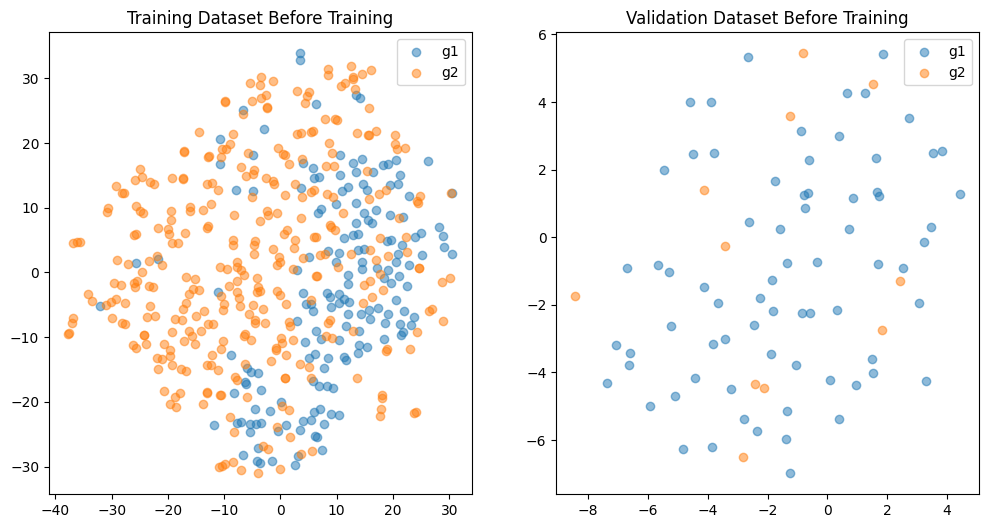

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target

Epoch 1: Saving new best model with val_accuracy 86.7470
Epoch 1: Train Loss 0.4184, Train Accuracy 33.3333, Val Loss 1.1573, Val Accuracy 86.7470
lr:  1e-06
Epoch 2: Saving new best model with val_accuracy 86.7470
Epoch 2: Train Loss 0.5772, Train Accuracy 33.3333, Val Loss 0.9389, Val Accuracy 86.7470
lr:  1e-06
Epoch 3: Saving new best model with val_accuracy 86.7470
Epoch 3: Train Loss 0.5083, Train Accuracy 33.3333, Val Loss 0.8710, Val Accuracy 86.7470
lr:  1e-06
Epoch 4: Saving new best model with val_accuracy 86.7470
Epoch 4: Train Loss 0.5084, Train Accuracy 33.3333, Val Loss 0.8149, Val Accuracy 86.7470
lr:  1e-06
Epoch 5: Saving new best model with val_accuracy 86.7470
Epoch 5: Train Loss 0.4610, Train Accuracy 33.3333, Val Loss 0.8128, Val Accuracy 86.7470
lr:  1e-06
Epoch 6: Saving new best model with val_accuracy 86.7470
Epoch 6: Train Loss 0.4638, Train Accuracy 33.3333, Val Loss 0.7495, Val Accuracy 86.7470
lr:  1e-06
Epoch 7: Saving new best model with val_accuracy 86.

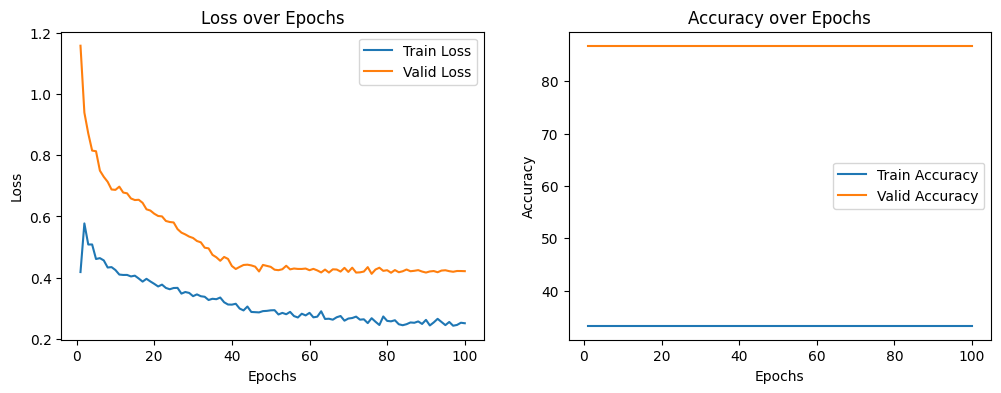

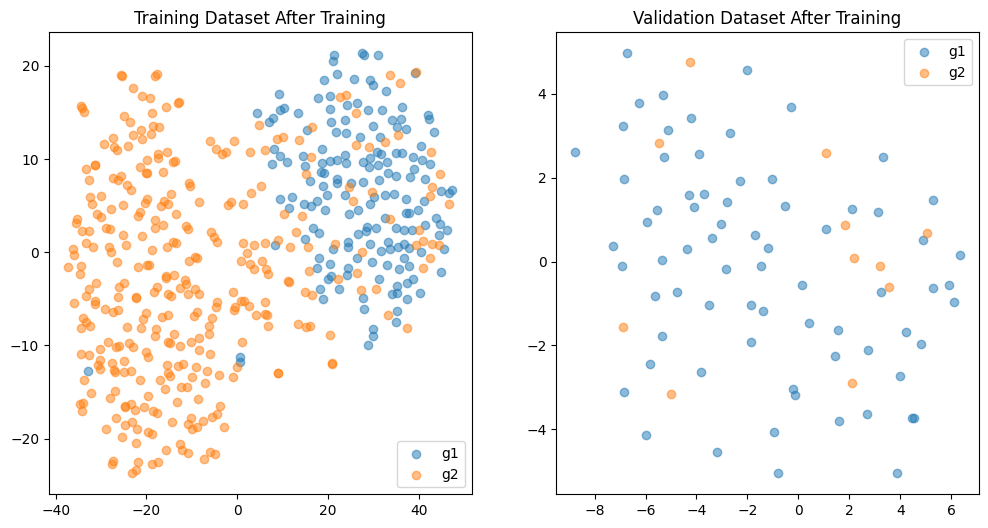

Accuracy for each class:
g1: 1.0000
g2: 0.0000


ValueError: n_components=2 must be between 1 and min(n_samples, n_features)=1 with svd_solver='randomized'

In [ ]:
if mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run():

    visualize_tsne_before_test(mult_model, train_dataloader, valid_dataloader)


    mlflow.log_params(params)
    best_model_state_dict = train(mult_model, train_dataloader, valid_dataloader, criterion, optimizer, scheduler, params["epochs"])
    mult_model.load_state_dict(best_model_state_dict)
    for epoch in range(params["epochs"]):
        mlflow.log_metric("train_loss", train_losses[epoch], step=epoch)
        mlflow.log_metric("valid_loss", val_losses[epoch], step=epoch)
        mlflow.log_metric("train_acc", train_accuracies[epoch], step=epoch)
        mlflow.log_metric("valid_acc", val_accuracies[epoch], step=epoch)

    # 그래프 그리기
    epochs_range = range(1, params["epochs"] + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Valid Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Valid Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.savefig("plot.png")
    mlflow.log_artifact("plot.png")
    plt.show()

    visualize_tsne_after_test(mult_model, train_dataloader, valid_dataloader)

    predict_and_visualize(mult_model, test_dataloader, 'model_state_dict.pth')
